# Importing the necessary modules

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load our csv file from local device

In [2]:
all_filenames = [i for i in os.listdir("C:\\Users\\Hp\\Desktop\\sagar file\\my project\\Nepali_news_classification-master\\News_Classification_Model\\CSV files") if  ".csv" in i and "combined" not in i]
print(all_filenames)

['Agriculture.csv', 'Automobiles.csv', 'Bank.csv', 'Business.csv', 'Economy.csv', 'Education.csv', 'Entertainment.csv', 'Health.csv', 'Politics.csv', 'Sports.csv', 'Technology.csv', 'Tourism.csv', 'World.csv']


# Getting the root of our csv data

In [3]:
root = "C:\\Users\\Hp\\Desktop\\sagar file\\my project\\Nepali_news_classification-master\\News_Classification_Model\\CSV files\\"

# Combining the multiple csv file into one file as combined_csv

In [4]:
combined_csv = pd.concat([pd.read_csv(root+f) for f in all_filenames])
combined_csv

,text,category
0,﻿काठमाडौंमा पहिलो पटक स्ट्रबेरीको व्यवसायिक खे...,Agriculture
1,"जिल्लाका किसानले लगाएको अदुवामा गानो कुहिने, ग...",Agriculture
2,काभ्रेपलाञ्चोकमा कृषकले एसआरआई प्रविधिमा गरेको...,Agriculture
3,राजधानीमा यतिबेला तरकारीको मूल्य आकासिएको छ। क...,Agriculture
4,पाल पोल्ट्री तथा लाइभस्टक क्षेत्रको समग्र विका...,Agriculture
...,...,...
117,\n﻿बिहार । मुकेश पाठक सहित आधा दर्जन कुख्यात अ...,world
118,"\n﻿राजविराज, २६ साउन । सप्तरी जिल्लामा पहिलो प...",world
119,"\n﻿वीरगञ्ज, ५ असोज । वीरगञ्जमा भव्यताका साथ वि...",world
120,"\n﻿वीरगञ्ज, ५ असोज । आत्मा ज्ञान प्रचार संघ वी...",world


## Here we are copying the orignal dataframe into df. In case if we change some file the copy dataframe will be change and original data will not be altered 

In [5]:
df = combined_csv.copy()

## We count the news per category

In [8]:
df[["text","category"]].groupby("category").count()

,text
category,
Agriculture,100
automobiles,95
bank,417
business,89
economy,100
education,85
entertainment,72
health,31
politics,2


## Bar plot of above frequency of text file per category

<Axes: xlabel='category'>

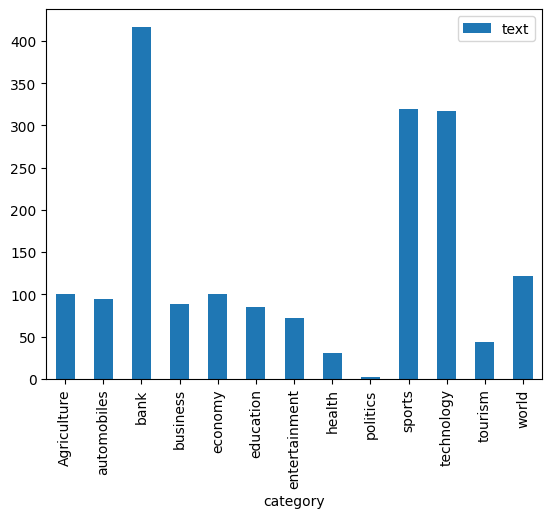

In [10]:
df[["text","category"]].groupby("category").count().plot(kind="bar")

# Load our Stopwords file

In [11]:
stop_file = "C:\\Users\\Hp\\Desktop\\sagar file\\my project\\Nepali_news_classification-master\\News_Classification_Model\\nepali_stopwords.txt"
stop_words = []
with open(stop_file, encoding='utf-8') as fp:
    lines = fp.readlines()
    stop_words =list( map(lambda x:x.strip(), lines))
# stop_words

# Load our Punctuation word file

In [12]:
punctuation_file = "C:\\Users\\Hp\\Desktop\\sagar file\\my project\\Nepali_news_classification-master\\News_Classification_Model\\nepali_punctuation.txt"
punctuation_words = []
with open(punctuation_file, encoding='utf-8') as fp:
    lines = fp.readlines()
    punctuation_words =list( map(lambda x:x.strip(), lines))
punctuation_words

[':', '?', '|', '!', '.', ',', '" "', "''", '( )', '—', '-', "?'", '\\n']

# Text pre-processing
### Here er wrote a method called preprocess_text that takes data, stop words, and punctuation words as parameters. Then, we created a list called new_cat to hold it. Also initialized noise as numbers. For each words:
   *  #### If word is not in punctuation or stop words then,
   *  #### Do not take this word if it contains noise characters.
   *  #### Remove parenthesis

In [13]:
def preprocess_text(cat_data, stop_words, punctuation_words):
  new_cat = []
  noise = "1,2,3,4,5,6,7,8,9,0,०,१,२,३,४,५,६,७,८,९".split(",")
  
  for row in cat_data:
    words = row.strip().split(" ")      
    nwords = "" # []
    
    for word in words:
     if word not in punctuation_words and word not in stop_words:
        is_noise = False
        for n in noise:
          #print(n)
          if n in word:
            is_noise = True
            break
        if is_noise == False:
          word = word.replace("(","")
          word = word.replace(")","")
          # nwords.append(word)
          if len(word)>1:
            nwords+=word+" "
          
    new_cat.append(nwords.strip())
  # print(new_cat)
  return new_cat

title_clean = preprocess_text(["\nसगरमाथा चुचुरोमा पुग्ने ९ शेर्पा टोलीको  नेतृत्व गरेको छ ।"], stop_words, punctuation_words)
print(title_clean)

['सगरमाथा चुचुरोमा पुग्ने शेर्पा टोलीको नेतृत्व']


In [14]:
ndf = df.copy()
cat_title = []
for i, row in ndf.iterrows():
  ndf.loc[i, "Title"]= preprocess_text([row.text], stop_words, punctuation_words)[0]

# ndf
#if you want to display the title of the news

# Importing the necessary module for Multinomial Naive Bayes

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Splitting data into Train and Test set
  ### Here we are splitting the Train data as 80% and Test data as 20%. Train data are used for model fitting and test data are used while doing model prediction. But before that, we     will merge two similar categories into one and also assign a unique label for each class.

In [16]:
data = pd.DataFrame()

data["text"]=ndf.text
# data["category"]=ndf.category

data["label"]=ndf.category
data["target"] = data["label"].apply(lambda x: "news" if x=="prabhas-news" else "national" if x=="province" else x)
classes = {c:i for i,c in enumerate(data.target.unique())}
data["target"] = data.target.apply(lambda x: classes[x])


X_train, X_test, Y_train, Y_test = train_test_split(data["text"],data["target"],test_size=0.2, random_state=1)

vectorizer = CountVectorizer(ngram_range=(1, 2)).fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)
print(X_train_vectorized)
X_train_vectorized.shape

  (0, 1470)	1
  (0, 1720)	1
  (0, 8906)	1
  (0, 8909)	1
  (0, 13458)	1
  (0, 13824)	1
  (0, 28061)	4
  (0, 28256)	1
  (0, 28469)	1
  (0, 28658)	1
  (0, 28982)	1
  (0, 29389)	1
  (0, 29469)	1
  (0, 29793)	2
  (0, 29807)	1
  (0, 29821)	1
  (0, 32474)	1
  (0, 32827)	1
  (0, 34124)	1
  (0, 34553)	1
  (0, 43278)	1
  (0, 43279)	1
  (0, 43400)	2
  (0, 43587)	1
  (0, 43774)	1
  :	:
  (1433, 26907)	1
  (1433, 27206)	1
  (1433, 32474)	1
  (1433, 38131)	1
  (1433, 38255)	1
  (1433, 40374)	1
  (1433, 40474)	1
  (1433, 43400)	3
  (1433, 43518)	1
  (1433, 43572)	1
  (1433, 43680)	1
  (1433, 45401)	1
  (1433, 45402)	1
  (1433, 62480)	1
  (1433, 63152)	1
  (1433, 68263)	1
  (1433, 68404)	1
  (1433, 85179)	1
  (1433, 85180)	1
  (1433, 90052)	1
  (1433, 90146)	1
  (1433, 91840)	1
  (1433, 91842)	1
  (1433, 102049)	1
  (1433, 102095)	1


(1434, 107209)

In [17]:
tfidf_transformer=TfidfTransformer()
X_train_tfidf=tfidf_transformer.fit_transform(X_train_vectorized)
X_train_tfidf.shape

(1434, 107209)

# Model Fitting 
### We fit MultinomialNB by using Train set of data. We get value of coefficent of determination 99.86% that means the model is able to fit only 99.86% of data.

In [19]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, Y_train)
model.score(X_train_vectorized, Y_train)

0.99860529986053

# Accuracy

In [20]:
predictions = model.predict(vectorizer.transform(X_test))
print("Accuracy:", 100 * sum(predictions == Y_test) / len(predictions), '%')

Accuracy: 83.008356545961 %


In [21]:
x_train_transformed = vectorizer.transform(X_test)

In [22]:
y_predicted = model.predict(x_train_transformed)

# Calculating the precison, recall and f1 score of out Test data set

In [23]:
PRECISION_SCORE = precision_score(Y_test, y_predicted, average='weighted')
RECALL_SCORE = recall_score(Y_test, y_predicted, average='weighted')
F1_SCORE = f1_score(Y_test, y_predicted, average='weighted')
print("PRECISION_SCORE :" ,PRECISION_SCORE)
print("RECALL_SCORE :" ,RECALL_SCORE)
print("F1_SCORE :" ,F1_SCORE)

PRECISION_SCORE : 0.867230286150636
RECALL_SCORE : 0.83008356545961
F1_SCORE : 0.8341629507092394


# Confusion Matrix

In [24]:
confusion_matrix(Y_test, y_predicted)

array([[15,  0,  0,  1,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 13,  2,  3,  1,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  1, 73,  1,  3,  0,  1,  0,  0,  0,  0,  1],
       [ 0,  0,  0, 19,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  4,  3,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  3,  2, 12,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  1,  0,  9,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  1],
       [ 0,  1,  0,  0,  1,  0,  1,  0, 59,  0,  0,  4],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0, 66,  0,  0],
       [ 0,  0,  0,  5,  3,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  1,  0,  1,  0,  2,  0,  0,  1,  0, 20]], dtype=int64)

# Creating the unique class for different category

In [25]:
model.classes_, classes

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64),
 {'Agriculture': 0,
  'automobiles': 1,
  'bank': 2,
  'business': 3,
  'economy': 4,
  'education': 5,
  'entertainment': 6,
  'health': 7,
  'politics': 8,
  'sports': 9,
  'technology': 10,
  'tourism': 11,
  'world': 12})

# Finally we predict our untrained data and try to find the right category

In [26]:
prd = model.predict(vectorizer.transform(
    [
      'केन्द्रिय बैंक नेपालमा राष्ट्रिय रूपमा वित्तीय नीति तथा कार्यक्रमहरु बनाउने र व्यवस्थापन गर्ने अधिकार राख्दछ। यो बैंक सरकारी बैंक हो जसले देशको वित्तीय नीति, नियम तथा कानून बनाउँदछ। केन्द्रिय बैंकले नेपालमा विभिन्न वित्तीय सेवाहरु प्रदान गर्दछ। उदाहरणको लागि, यो बैंक स्थानिय वित्तीय संस्थाहरु सँग भुक्तानी सम्बन्धित सेवाहरु प्रदान गर्दछ। केन्द्रिय बैंकले नेपालमा विभिन्न वित्तीय नीति तथा कार्यक्रमहरु लागू गर्दछ। उदाहरणको लागि, यो बैंक ब्याज दर, रिपोर्टिङ, स्टैटस र विभिन्न वित्तीय रिपोर्टहरु जारी गर्दछ। केन्द्रिय बैंक नेपालमा नियमित रूपमा नियोजित गरिएको छ। यो बैंकले विभिन्न वित्तीय निकायहरुमा काम गर्दछ र देशको वित्तीय स्थिति अध्ययन गर्दछ।'
    ])
            ) 
nprd = []
for k,v in classes.items():
  for p in prd:
    if v==p:
      nprd.append(k)
nprd

['business']

In [27]:
import pickle

In [28]:
filename = 'news_pred_model.pickle'
pickle.dump(model,open(filename,'wb'))

In [29]:
filename = 'news_pred_vectorizer.pickle'
pickle.dump(vectorizer,open(filename,'wb'))